In [118]:
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm

from mpl_toolkits.mplot3d import Axes3D

from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny

In [119]:
#p is of size R^(Nx3)
def projPointCam(p, fx, fy, cx, cy):
    if p.shape == (3,):
        p = np.expand_dims(p, axis=0)
    K = np.array([[fx, 0,   cx],
                  [  0, fy, cy],
                  [  0,  0, 1]])
    divide_z = np.divide(p[:,:-1].transpose(), p[:,-1].transpose())
    divide_z = np.vstack( (divide_z, np.ones( (1,p.shape[0]) ) ) )
    return np.dot(K, divide_z )[:-1, :].transpose()


def quadraticBezierCurve(p0, p1, p2, n=100):
    out = np.zeros((n, 3))
    for i in range(n):
        t = float(i)/float(n)
        out[i, :] = (1 - t)**2 * p0 + 2*(1 - t)*t*p1 + t**2 * p2
    return out

def derivativeOfquadraticBezierCurve(p0, p1, p2, n=100):
    out = np.zeros((n, 3))
    for i in range(n):
        t = float(i)/float(n)
        out[i, :] = 2*(1-t)*(p1 - p0) + 2*t*(p2 - p1)
    return out

In [120]:
#position and direction must be 3D and defined in the camera frame.
def projectCylinder(position, direction, R, fx, fy, cx, cy):
    a = direction[0]
    b = direction[1]
    c = direction[2]

    x0 = position[0]
    y0 = position[1]
    z0 = position[2]


    alpha1 = (1-a*a)*x0 - a*b*y0 - a*c*z0
    beta1  = -a*b*x0 + (1 - b*b)*y0 - b*c*z0
    gamma1 = -a*c*x0 - b*c*y0 + (1 - c*c)*z0

    alpha2 = c*y0 - b*z0
    beta2  = a*z0 - c*x0
    gamma2 = b*x0 - a*y0

    C = x0*x0 + y0*y0 + z0*z0 - (a*x0 + b*y0 + c*z0)*(a*x0 + b*y0 + c*z0) - R*R
    
    if C < 0:
        print("Recieved C less than 0")
        return (-1, -1), (-1, -1)


    temp = R/math.sqrt(C)

    k1   = (alpha1*temp - alpha2)
    k2   = (beta1* temp - beta2 )
    k3   = (gamma1*temp - gamma2)

    #Get edges! Fu + Gv = D convert to hough trnasform cos(theta)u + sin(theta)v = r
    F = k1/fx 
    G = k2/fy 
    D = -k3 + F*cx + G*cy

    # Distance can be negative in our HT world,
    if D < 0:
        D = -D
        G = -G
        F = -F
         
    # arctan2 range is -pi, pi so maybe switch to arctan which is -pi/2.0 to pi/2.0
    e_1 = (D/math.sqrt(F*F + G*G), np.arctan2(G,F))
    #e_1 = (D/math.sqrt(F*F + G*G), np.arctan2(G/F))
    
    k1 += 2*alpha2
    k2 += 2*beta2
    k3 += 2*gamma2

    F = k1/fx
    G = k2/fy
    D = -k3 + F*cx + G*cy

    if D < 0:
        D = -D
        G = -G
        F = -F

    e_2 = (D/math.sqrt(F*F + G*G), np.arctan2(G,F))
    #e_2 = (D/math.sqrt(F*F + G*G), np.arctan(G/F))
    return e_1, e_2

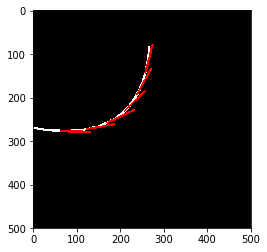

In [121]:
p0 = np.array([-500.0, 0.0, 1.5])
p1 = np.array([0.0,  150.0, 1.5])
p2 = np.array([25.0, -250.0, 1.5])
w = 500
h = 500
fx = 1.0
fy = 1.0

cx = w/2.0
cy = h/2.0
l = 100.0
n = 200


K = np.array([[fx,  0, cx,],
              [0,  fy, cy,],
              [0,   0,  1]])

im = np.zeros((w, h, 3))

curve   = quadraticBezierCurve(p0, p1, p2, n=n)
d_curve = derivativeOfquadraticBezierCurve(p0, p1, p2, n=n)

p_curve = projPointCam(curve, fx, fy, cx, cy).astype(int)
# p_curve = np.delete(p_curve, np.where(p_curve < 0)[0], axis=0)


#Draw centerline
for i,p in enumerate(p_curve):
    if p[0] < 0 or p[1] < 0:
        continue
    
    im[p[1], p[0], :] = 1
    
    

im = cv2.dilate(im, np.ones((5,5)) ,iterations = 1)
    
#Draw tangents:
for i,p in enumerate(p_curve):
    if i % 25 != 0:
        continue
    
    p_d = projPointCam(curve[i] + l*d_curve[i]/np.linalg.norm(d_curve[i]), fx, fy, cx, cy)[0].astype(int)
    if p_d[0] < 0 or p_d[1] < 0 or p[0] < 0 or p[1] < 0:
        continue
    im = cv2.line(im, (p[0], p[1]), (p_d[0], p_d[1]), (1.0, 0.0, 0.0), 3)

plt.imshow(im)



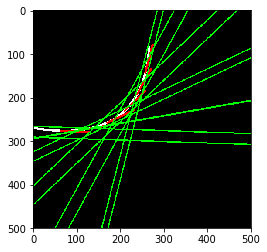

In [122]:
#Draw the cylinders
for i,p in enumerate(p_curve):
    if i % 25 != 0:
        continue
    
    #If the centerline point is out of image frame
    if p[0] < 0 or p[1] < 0 or p[0] > w or p[1] > h:
        continue
    
    R = 0.5
    s_i = float(i)/float(n)
    e_1, e_2 = projectCylinder(curve[i] - s_i*d_curve[i], d_curve[i]/np.linalg.norm(d_curve[i]), R, fx, fy, cx, cy)
        
    a = np.cos(e_1[1])
    b = np.sin(e_1[1])
    x0 = a*e_1[0]
    y0 = b*e_1[0]
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    
    cv2.line(im,(x1,y1),(x2,y2),(0,1.0,0), 2)
    
    a = np.cos(e_2[1])
    b = np.sin(e_2[1])
    x0 = a*e_2[0]
    y0 = b*e_2[0]
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    
    cv2.line(im,(x1,y1),(x2,y2),(0,1.0,0), 2)
    
plt.imshow(im)

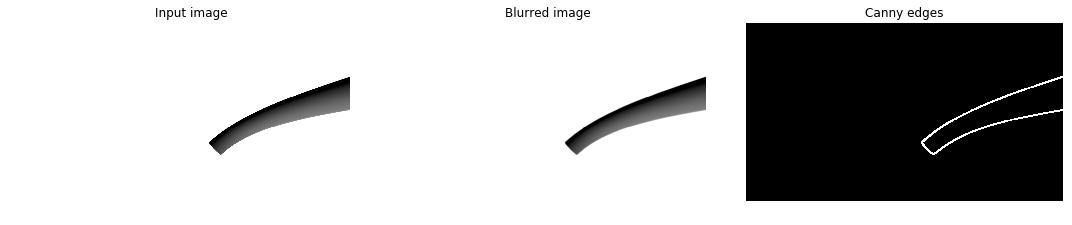

In [123]:
img_path = "test1.png"
downscale = 2.0
gaussian_blur_kern_size = 5 #This doesn't make that big of a difference on synthetic images
dilate_iterations = 1

raw_img_rgb = cv2.imread(img_path)
raw_img_rgb = cv2.resize(raw_img_rgb, (int(raw_img_rgb.shape[1]/downscale), int(raw_img_rgb.shape[0]/downscale)))
raw_img = cv2.cvtColor(raw_img_rgb, cv2.COLOR_RGB2GRAY)
# plt.imshow(raw_img)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ax = axes.ravel()

blur_raw_img = cv2.GaussianBlur(raw_img,(gaussian_blur_kern_size, gaussian_blur_kern_size),0)

edges_img = canny(blur_raw_img, 2, 1, 100)
edges_img = cv2.dilate(edges_img.astype(np.uint8), np.ones((5,5),np.uint8), iterations = dilate_iterations)

ax[0].imshow(raw_img, cmap=cm.gray)
ax[0].set_title('Input image')

ax[1].imshow(blur_raw_img, cmap=cm.gray)
ax[1].set_title('Blurred image')

ax[2].imshow(edges_img, cmap=cm.gray)
ax[2].set_title('Canny edges')

ax[2].set_xlim((0, raw_img.shape[1]))
ax[2].set_ylim((raw_img.shape[0], 0))


for a in ax:
    a.set_axis_off()
plt.tight_layout()


plt.show()

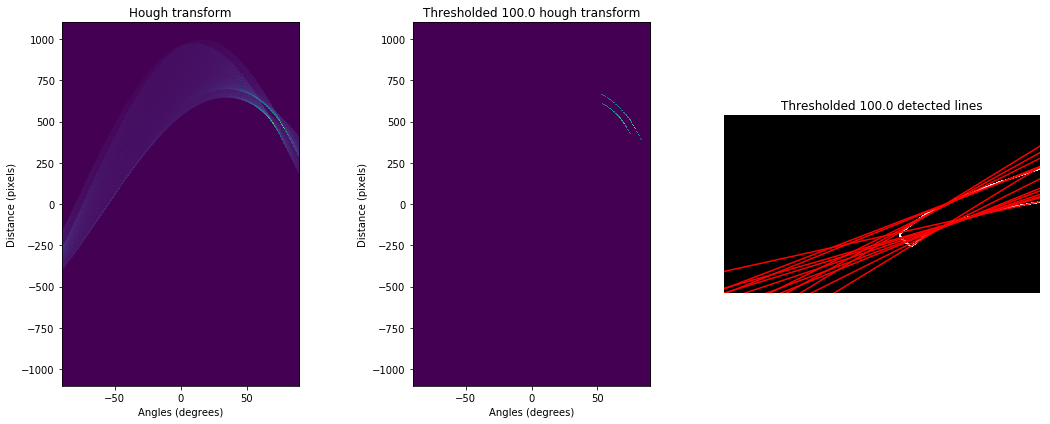

In [125]:
threshold = 100.0

# Classic straight-line Hough transform
# Set a precision of 1.0 degree.
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
h, theta, d = hough_line(edges_img, theta=tested_angles)
h = np.flip(h, axis=0)

# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[0] - d_step, d[-1] + d_step]

ax[0].imshow(h.astype(float)/np.sum(h.astype(float)), extent=bounds)
ax[0].set_title('Hough transform')
ax[0].set_xlabel('Angles (degrees)')
ax[0].set_ylabel('Distance (pixels)')
ax[0].set_aspect(1.0/8.0)

h_thresh = h.astype(float)*(h>threshold)
ax[1].imshow(h_thresh/np.sum(h_thresh.astype(float)), extent=bounds)
ax[1].set_title('Thresholded {} hough transform'.format(threshold))
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].set_aspect(1.0/8.0)


h = np.flip(h, axis=0)
ax[2].imshow(edges_img, cmap=cm.gray)
origin = np.array((0, edges_img.shape[1]))
for _, angle, dist in zip(*hough_line_peaks(h, theta, d, threshold=threshold)):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    ax[2].plot(origin, (y0, y1), '-r')
ax[2].set_xlim(origin)
ax[2].set_ylim((edges_img.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Thresholded {} detected lines'.format(threshold))

plt.tight_layout()
plt.show()


In [74]:
def isPointInImage(p_proj, width, height):
    if np.isnan(p_proj).any():
        return False
    if p_proj[0] < 0 or p_proj[1] < 0 or p_proj[0] > width or p_proj[1] > height:
        return False
        
    return True

cam_K: 
[[ 240.    0.  480.]
 [   0.  216.  270.]
 [   0.    0.    1.]]


/Library/Python/2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in divide
  


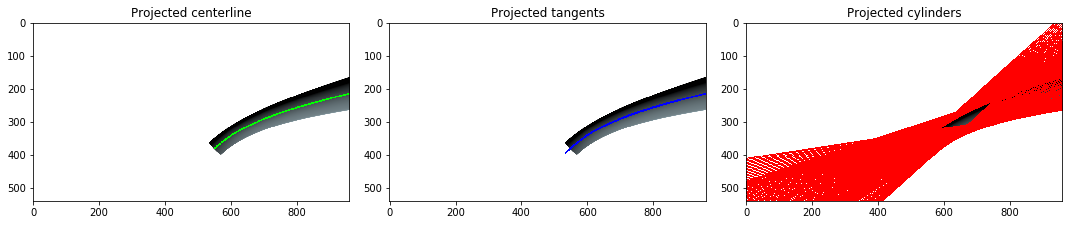

In [77]:
r = 0.1
num_samples = 100

P1  = np.array([0., 0., 0.])
P1p = np.array([0., 0., 0.545620283957689])
P2  = np.array([0.707106781186548, 0.707106781186548, 1.])
P2p = np.array([1.092055813370492, 1.092055813370492, 1.])

cam_RT_H =  np.array([[-1., 0., 0., 1. ],
                      [ 0.,-1., 0., 0.2],
                      [ 0., 0., 1., 0.],
                      [ 0., 0., 0., 1.]])
# Render thing
invert_y = np.array([[  1., 0., 0., 0. ],
                      [ 0.,-1., 0., 0.],
                      [ 0., 0., 1., 0.],
                      [ 0., 0., 0., 1.]])
cam_RT_H = np.dot(invert_y, cam_RT_H)

res_width = 1920.0;
res_height = 1080.0;

# This FOV stuff doesn't work??
# fov = 126.8699
# angle_view = fov / 1.0
# angle_view = (180.0 / np.pi) * 2.0 * atan2(res_height/ 2.0, f);
# tan( pi * angle_view / ( 180.0 * 2.0 ) ) = res_height / ( 2.0 * f )
# f = res_height / ( 2.0 * np.tan( np.pi * angle_view / ( 180.0 * 2.0 ) ) )

cam_K = np.array([[480.0, 0, res_width/2.0],
                  [0, 432.0, res_height/2.0],
                  [0, 0, 1.0]])

cam_K = cam_K/downscale
cam_K[-1,-1] = 1

print("cam_K: ")
print(cam_K)

sample_list = np.linspace(0, 1, num_samples, endpoint=True)

# Get positions and normals from samples along bezier curve
pos_bezier = np.zeros((num_samples, 3))
der_bezier = np.zeros((num_samples, 3))
for i, s in enumerate(sample_list):
    pos_bezier[i, :] = (1-s)**3*P1 + 3*s*(1-s)**2*P1p + 3*(1-s)*s**2*(2*P2-P2p) + s**3*P2;
    der_bezier[i, :] = -(1-s)**2*P1 + ((1-s)**2-2*s*(1-s))*P1p + (-3*s**2+2*s)*(2*P2-P2p) + s**2*P2
    
# Convert positions and normals to camera frame
pos_bezier_H = np.concatenate((pos_bezier, np.ones((num_samples, 1))), axis=1)
pos_bezier_cam_H = np.dot(cam_RT_H, pos_bezier_H.transpose()).transpose()
pos_bezier_cam   = pos_bezier_cam_H[:, :-1]

der_bezier_H = np.concatenate((der_bezier, np.zeros((num_samples, 1))), axis=1)
der_bezier_cam_H = np.dot(cam_RT_H, der_bezier_H.transpose()).transpose()
der_bezier_cam   = der_bezier_cam_H[:, :-1]

# Plot centerline positions and normals over image to verify it looks right
proj_bezier_cam = projPointCam(pos_bezier_cam, cam_K[0,0], cam_K[1,1], cam_K[0,-1], cam_K[1,-1])

centerline_draw_img_rgb = raw_img_rgb.copy()

# Draw centerline
for i in range(proj_bezier_cam.shape[0]-1):
    if not isPointInImage(proj_bezier_cam[i,:], 
                          centerline_draw_img_rgb.shape[1],
                          centerline_draw_img_rgb.shape[0]):
        continue
    if not isPointInImage(proj_bezier_cam[i+1,:],
                          centerline_draw_img_rgb.shape[1], 
                          centerline_draw_img_rgb.shape[0]):
        continue
        
    p1 = (int(proj_bezier_cam[i,0]), int(proj_bezier_cam[i,1]))
    p2 = (int(proj_bezier_cam[i+1,0]), int(proj_bezier_cam[i+1,1]))
    cv2.line(centerline_draw_img_rgb, p1,p2,(0,255,0), 3)
    

# Draw tangent lines every few to check they are correct   
show_every_so_many_samples = 1
l = 0.1
tangent_draw_img_rgb = centerline_draw_img_rgb.copy()
for i,p in enumerate(proj_bezier_cam):
    if i % show_every_so_many_samples != 0:
        continue
        
    if not isPointInImage(p, tangent_draw_img_rgb.shape[1], tangent_draw_img_rgb.shape[0]):
        continue
        
    p_d = projPointCam(pos_bezier_cam[i] + l*der_bezier_cam[i]/np.linalg.norm(der_bezier_cam[i]), 
                       cam_K[0,0], cam_K[1,1], cam_K[0,-1], cam_K[1,-1])[0].astype(int)

    if not isPointInImage(p_d, tangent_draw_img_rgb.shape[1], tangent_draw_img_rgb.shape[0]):
        continue
    
    tangent_draw_img_rgb = cv2.line(tangent_draw_img_rgb, (int(p[0]), int(p[1])), 
                                    (int(p_d[0]), int(p_d[1])), (0.0, 0.0, 255.0), 3)



list_of_edges = []

# Draw projected cylinder
cylinder_draw_img_rgb = raw_img_rgb.copy()
for i, p in enumerate(proj_bezier_cam):
    #If the centerline point is out of image frame
    if not isPointInImage(p, cylinder_draw_img_rgb.shape[1], cylinder_draw_img_rgb.shape[0]):
        continue
        
    s_i = float(i)/float(num_samples - 1)
    
    pos_on_cylinder = pos_bezier_cam[i,:]
    norm_for_cylinder = der_bezier_cam[i]/np.linalg.norm(der_bezier_cam[i])
    
    e_1, e_2 = projectCylinder(pos_on_cylinder, norm_for_cylinder, 
                               r, cam_K[0,0], cam_K[1,1], cam_K[0,-1], cam_K[1,-1])
    if e_1 == (-1, -1) and e_2 == (-1, -1):
        continue
    a = np.cos(e_1[1])
    b = np.sin(e_1[1])
    x0 = a*e_1[0]
    y0 = b*e_1[0]
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    
    cv2.line(cylinder_draw_img_rgb,(x1,y1),(x2,y2),(255,0,0), 2)
    
    a = np.cos(e_2[1])
    b = np.sin(e_2[1])
    x0 = a*e_2[0]
    y0 = b*e_2[0]
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    
    cv2.line(cylinder_draw_img_rgb,(x1,y1),(x2,y2),(255,0,0), 2)
    
    list_of_edges.append(e_1)
    list_of_edges.append(e_2)
    
    
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ax = axes.ravel()

ax[0].imshow(centerline_draw_img_rgb)
ax[0].set_title('Projected centerline')

ax[1].imshow(tangent_draw_img_rgb)
ax[1].set_title('Projected tangents')

ax[2].imshow(cylinder_draw_img_rgb)
ax[2].set_title('Projected cylinders')

plt.tight_layout()
plt.show()

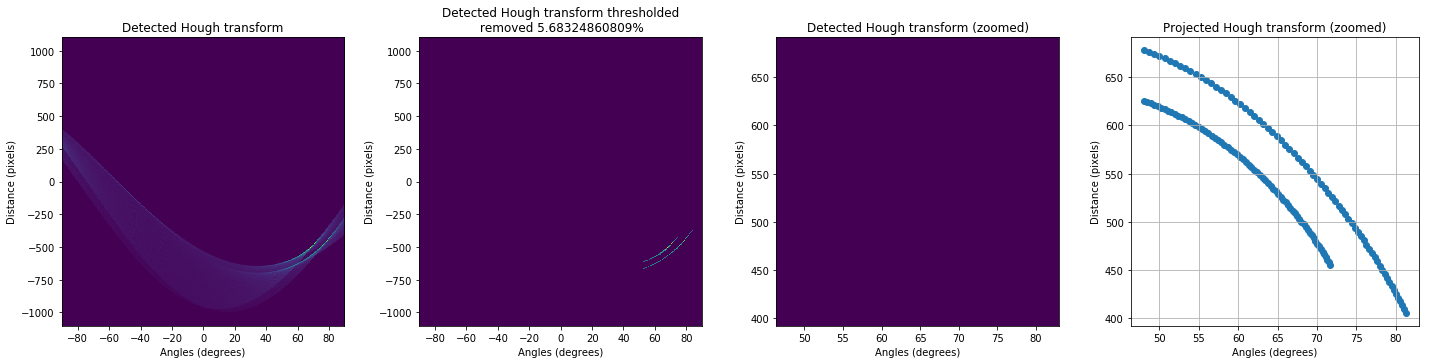

In [137]:
list_of_edges = np.array(list_of_edges)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
ax = axes.ravel()

ax[0].imshow(h.astype(float)/np.sum(h.astype(float)), extent=bounds)
ax[0].set_title('Detected Hough transform')
ax[0].set_xlabel('Angles (degrees)')
ax[0].set_ylabel('Distance (pixels)')
ax[0].set_aspect(1.0/12.0)


h_thresh = h.astype(float)*(h>threshold)


perc_thresh = np.sum(np.where(threshold > h, 0, h))/np.sum(h.astype(float))*100
ax[1].imshow(h_thresh.astype(float)/np.sum(h_thresh.astype(float)), extent=bounds)
ax[1].set_title('Detected Hough transform thresholded\n removed {}%'.format(perc_thresh))
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].set_aspect(1.0/12.0)



ax[3].scatter(list_of_edges[:,1]*180.0/np.pi, list_of_edges[:,0])
ax[3].grid()
ax[3].set_title("Projected Hough transform (zoomed)")
ax[3].set_xlabel('Angles (degrees)')
ax[3].set_ylabel('Distance (pixels)')


ax[2].imshow(h_thresh.astype(float)/np.sum(h_thresh.astype(float)), extent=bounds)
ax[2].set_title('Detected Hough transform (zoomed)')
ax[2].set_xlabel('Angles (degrees)')
ax[2].set_ylabel('Distance (pixels)')
ax[2].set_aspect(1.0/8.0)
ax[2].set_xlim(ax[3].get_xlim())
ax[2].set_ylim(ax[3].get_ylim())


plt.tight_layout()
plt.show()